### Read the data

In [5]:
%matplotlib widget

import rasterio as rio
import cfar_filters as cfar

# load your SAR image as a numpy array (the image loaded here in in dB scale)
with rio.open('sentinel1-image.tif') as src:
    db_image = src.read()

# load the mask (mask optional)
with rio.open('sentinel1-mask.tif') as src:
    mask = src.read(1)
    
# convert mask to bool
mask = mask>0

(2, 2025, 1731)
(2025, 1731)


Text(0.5, 1.0, 'Mask')

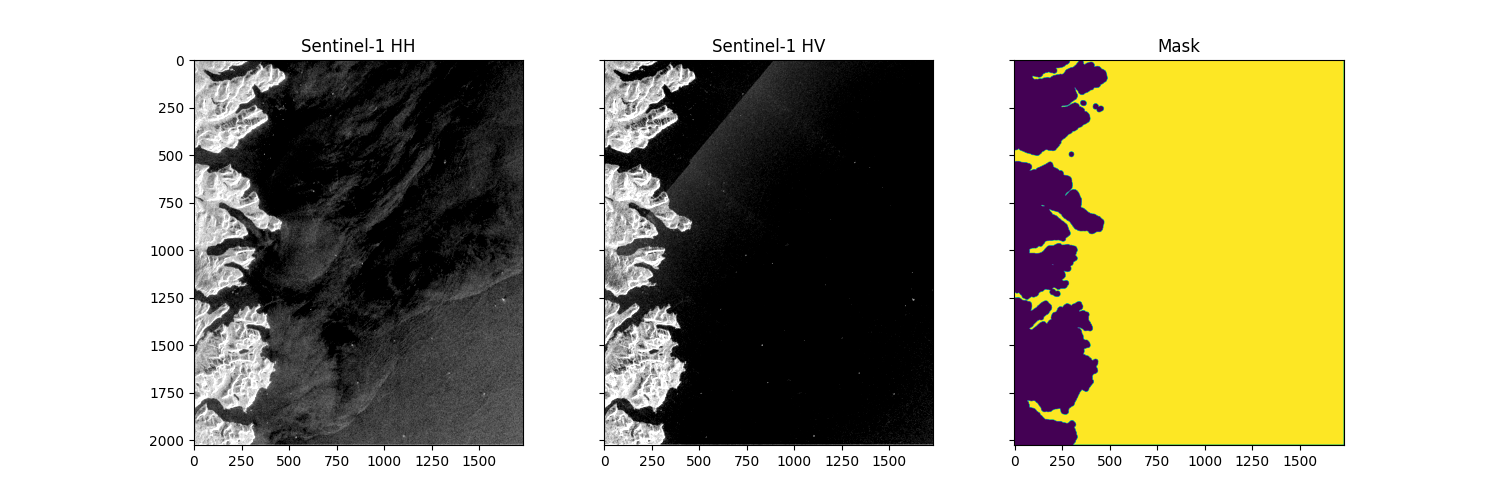

In [6]:
import matplotlib.pyplot as plt

# inpect the shapes of the data and plot the data
print(db_image.shape)
print(mask.shape)

fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,5))
ax[0].imshow(db_image[0,...], vmin=-30, vmax=-5, cmap='gray')
ax[0].set_title('Sentinel-1 HH')

ax[1].imshow(db_image[1,...], vmin=-35, vmax=-15, cmap='gray')
ax[1].set_title('Sentinel-1 HV')

ax[2].imshow(mask)
ax[2].set_title('Mask')

(2025, 1731)


Text(0.5, 1.0, 'Given mask')

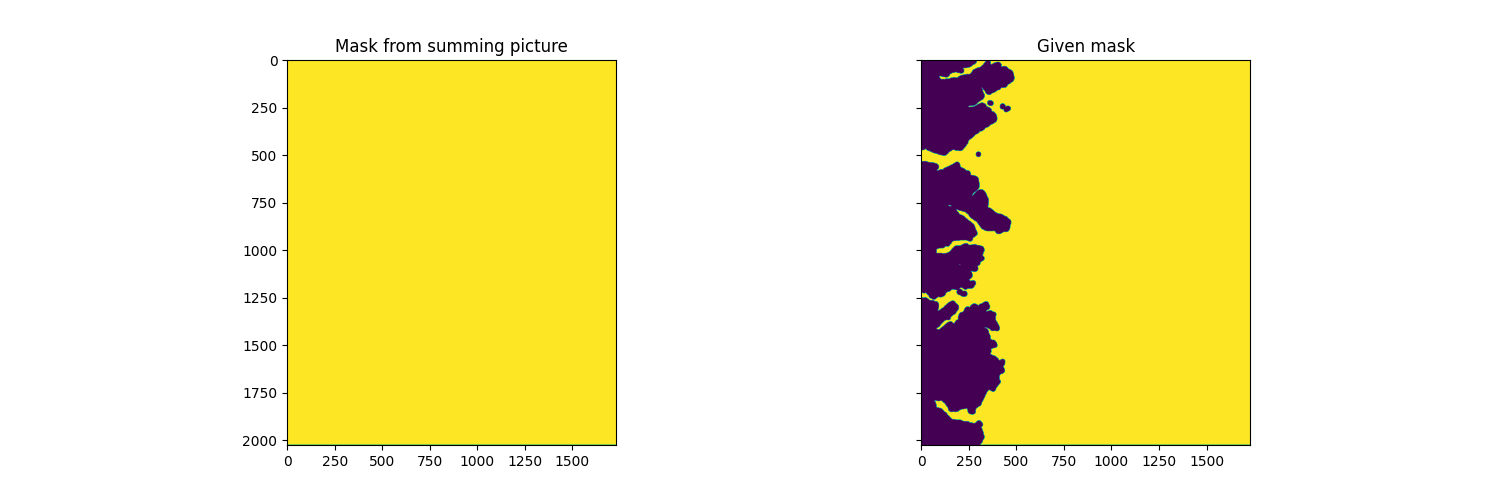

In [7]:
import numpy as np

cmask = np.nansum(db_image, axis=0)!=0

print(cmask.shape)

fig, ax = plt.subplots(1, 2, sharex = True, sharey=True, figsize=(15,5))
ax[0].imshow(cmask)
ax[0].set_title('Mask from summing picture')

ax[1].imshow(mask)
ax[1].set_title('Given mask')

### Single band detection (testing the detector on the HV channel)

In [8]:
from cfar_filters.utils import db2in, in2db # conversion between decibel and intensity

# define the detection parameters
pfa = 1e-9  # probability of false alarm rate
enl = 10.7  # equivalent number of looks of the image
wi = 9  # diameter of the guard area
wo = 15  # diameter of the clutter estimation area

# using the gamma detector (the gamma detector assumes data is in intensity scale, so we convert before calling the function)
in_image = cfar.utils.db2in(db_image)  # convert image to decibel using .utils
gamma_outliers = cfar.gamma.detector(in_image[1,...], mask, pfa, enl, wi, wo)

# using the lognormal detector (lognormal detector assumes data is in decibel (log) scale)
lognormal_outliers = cfar.lognormal.detector(db_image[1,...], mask, pfa, wi, wo)

# using the k detector (k detector assumes data is in intensity scale)
N = 40  # number of steps for the LUT
k_outliers = cfar.kdistribution.detector(in_image[1,...], mask, N, pfa, enl, wi, wo)

# remove objects smaller than 3 using .utils
gamma_outliers = cfar.utils.remove_small_objects(gamma_outliers, 2)
lognormal_outliers = cfar.utils.remove_small_objects(lognormal_outliers, 2)
k_outliers = cfar.utils.remove_small_objects(k_outliers, 2)

C:\cfar-object-detection\cfar_filters\kdistribution.py:120: RuntimeWarning: invalid value encountered in divide
  order_param = edge_mean**2 * (enl + 1) / np.where(mask, (egde_var * enl - edge_mean**2), np.nan)


Text(0.5, 1.0, 'K-distribution detector')

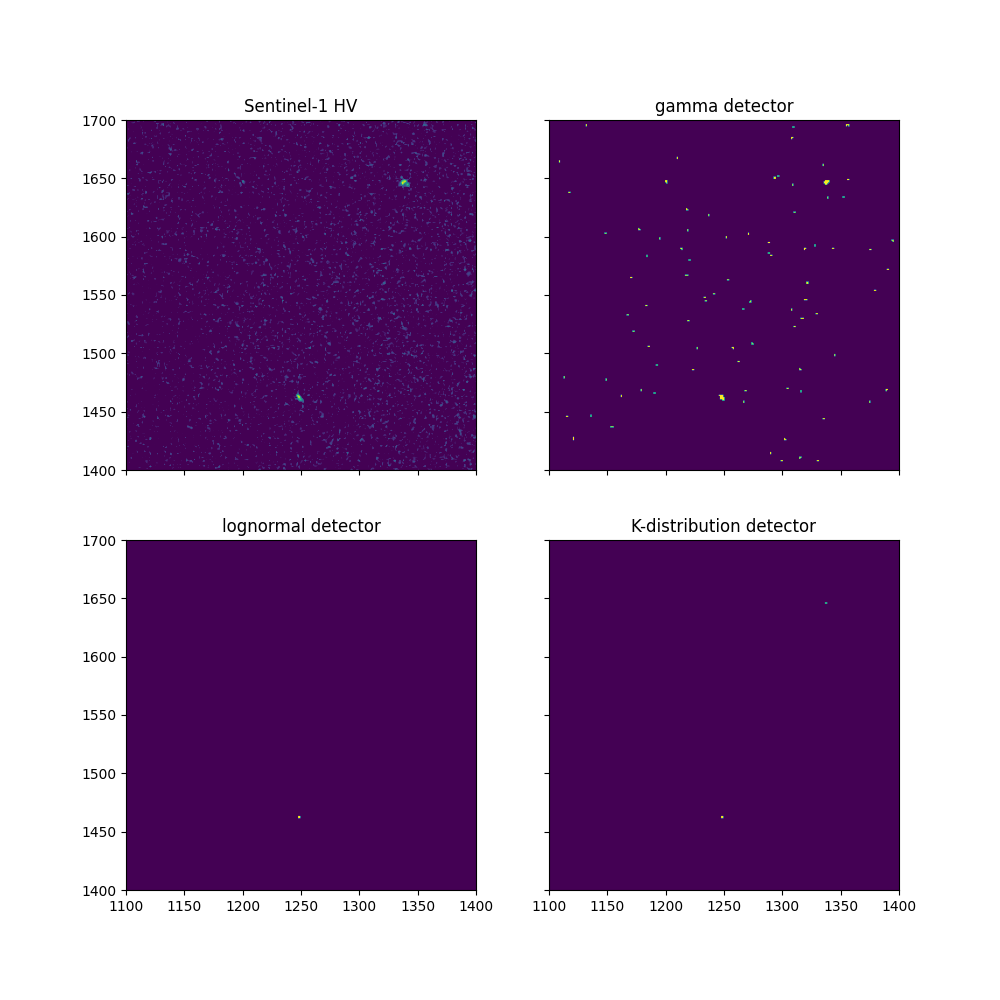

In [9]:
### Plot the results

# zoom in on some icebergs as defined by x and y limits
xlim = (1100, 1400)
ylim = (1400, 1700)

fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10,10))
ax[0,0].imshow(db_image[1,...]*mask, vmin=-35, vmax=-15)
ax[0,0].set_title('Sentinel-1 HV')
ax[0,0].set_xlim(xlim)
ax[0,0].set_ylim(ylim)

ax[0,1].imshow(gamma_outliers)
ax[0,1].set_title('gamma detector')


ax[1,0].imshow(lognormal_outliers)
ax[1,0].set_title('lognormal detector')

ax[1,1].imshow(k_outliers)
ax[1,1].set_title('K-distribution detector')

### Dual-band detection

In [10]:
# initialize detector setting
init = {
        'detector' : 'gamma', # use: 'gamma', 'lognorm', 'k', 'wishart', 'nis', 'idpolrad'
        'method' : 'AND', # use: 'AND', 'OR'. Not used by 'wishart', 'nis', and 'idpolrad'
        'pfa' :  1e-12, # recommended range: 1e-21 - 1e-3
        'enl' : 10.7, # use sensor ENL, 10.7 for Sentinel-1 EW
        'minsize' : 2, # objects smaller than this size are removed
        'sensitivity' : 40, # Only used by the k-algorithm. Higher number means slower and more precise
        'wi' : 9 , # diameter of the guard area
        'wo' : 15  # diameter of the clutter estimation area
        }

# for dual-band detectors, use the image in decibel format (they are converted in the detector.run function)
gamma_outliers = cfar.detector.run(db_image, mask, **init)

init.update({'detector': 'lognorm'})
lognorm_outliers = cfar.detector.run(db_image, mask, **init)

init.update({'detector': 'k'})
k_outliers = cfar.detector.run(db_image, mask, **init)

init.update({'detector': 'wishart'})
wishart_outliers = cfar.detector.run(db_image, mask, **init)

init.update({'detector': 'nis'})
nis_outliers = cfar.detector.run(db_image, mask, **init)

init.update({'detector': 'idpolrad'})
idpolrad_outliers = cfar.detector.run(db_image, mask, **init)

C:\cfar-object-detection\cfar_filters\kdistribution.py:120: RuntimeWarning: invalid value encountered in divide
  order_param = edge_mean**2 * (enl + 1) / np.where(mask, (egde_var * enl - edge_mean**2), np.nan)
C:\cfar-object-detection\cfar_filters\kdistribution.py:120: RuntimeWarning: invalid value encountered in divide
  order_param = edge_mean**2 * (enl + 1) / np.where(mask, (egde_var * enl - edge_mean**2), np.nan)


Text(0.5, 1.0, 'IDPOLRAD detector')

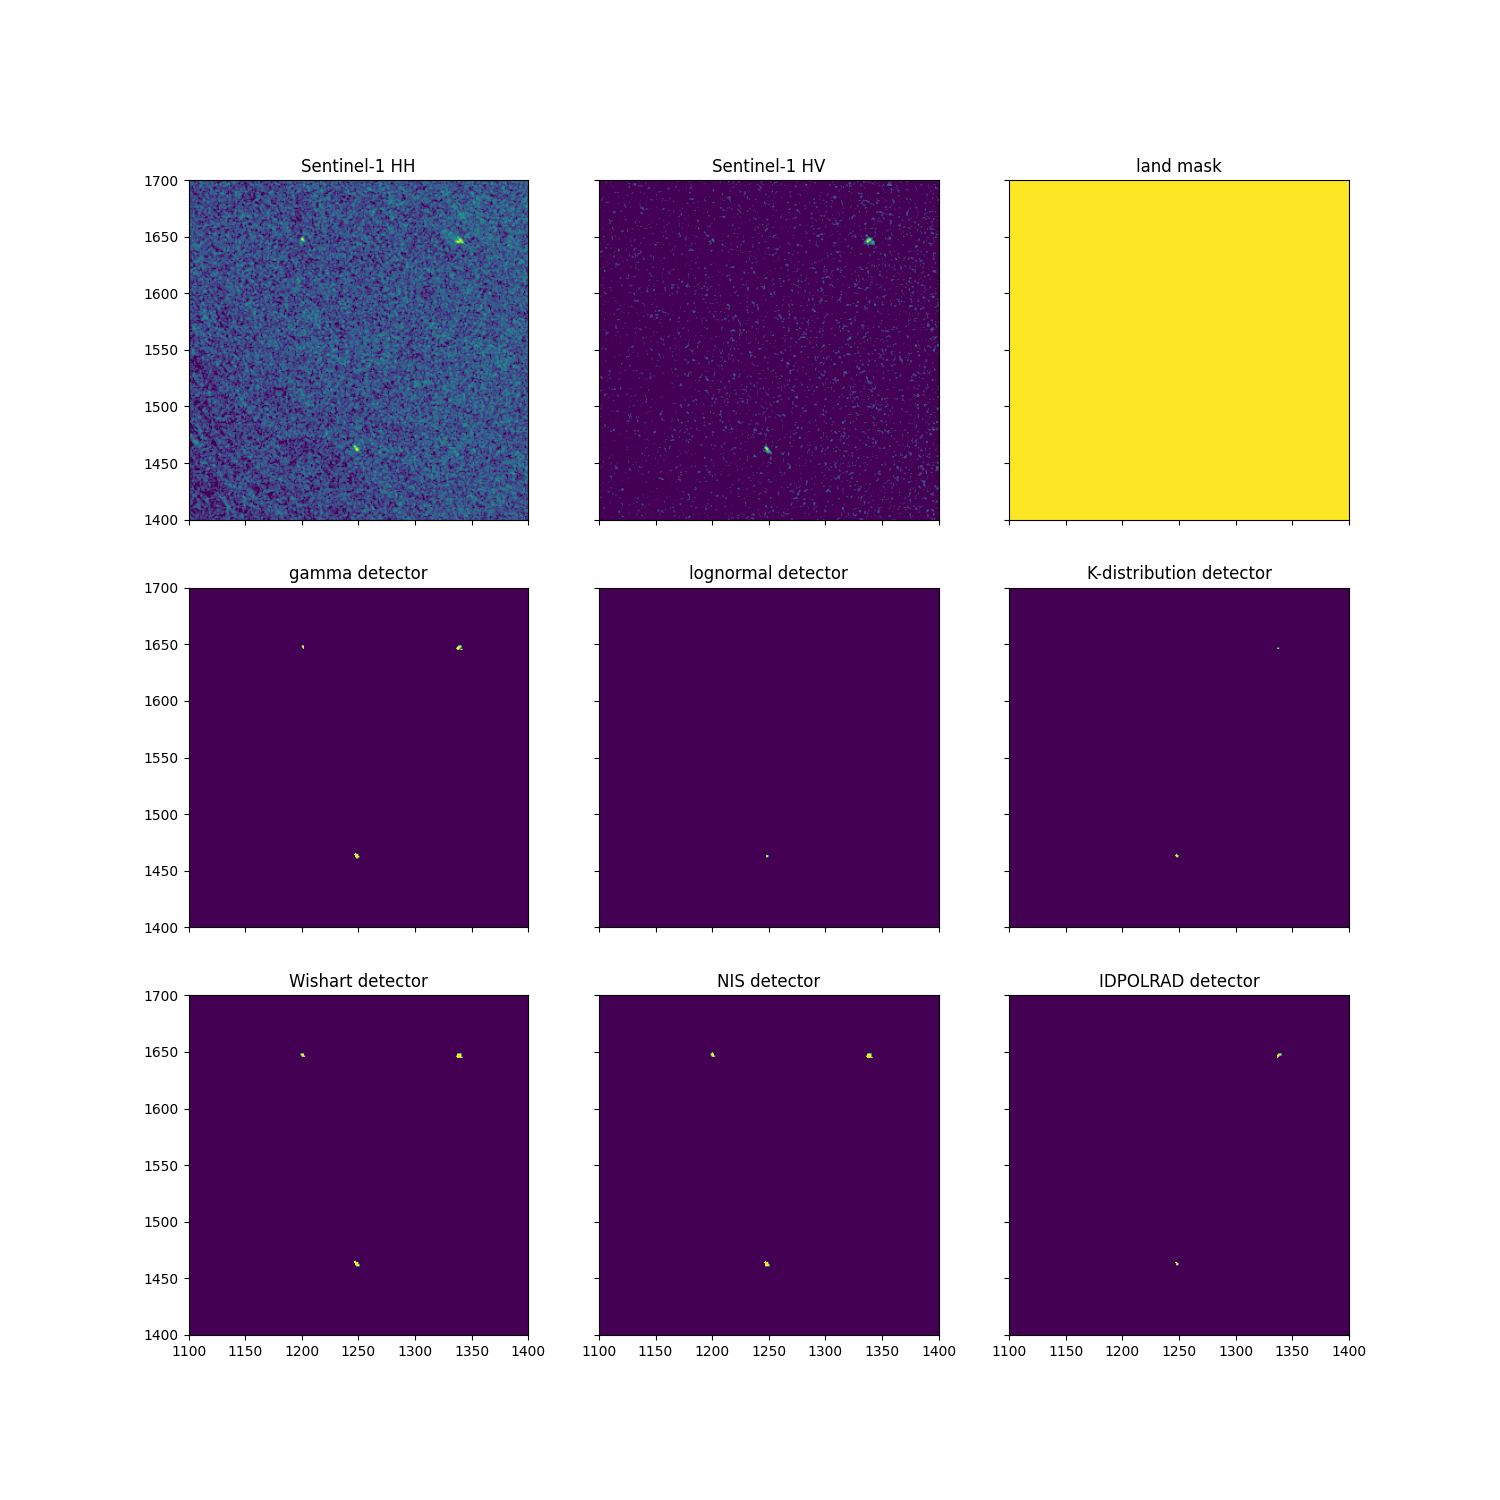

In [15]:
### Plot the results

fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(15,15))

ax[0,0].imshow(db_image[0,...], vmin=-30, vmax=-5)
ax[0,0].set_title('Sentinel-1 HH')
ax[0,0].set_xlim(xlim)
ax[0,0].set_ylim(ylim)

ax[0,1].imshow(db_image[1,...], vmin=-35, vmax=-15)
ax[0,1].set_title('Sentinel-1 HV')

ax[0,2].imshow(mask)
ax[0,2].set_title('land mask')

ax[1,0].imshow(gamma_outliers)
ax[1,0].set_title('gamma detector')

ax[1,1].imshow(lognormal_outliers)
ax[1,1].set_title('lognormal detector')

ax[1,2].imshow(k_outliers)
ax[1,2].set_title('K-distribution detector')

ax[2,0].imshow(wishart_outliers)
ax[2,0].set_title('Wishart detector')

ax[2,1].imshow(nis_outliers)
ax[2,1].set_title('NIS detector')

ax[2,2].imshow(idpolrad_outliers)
ax[2,2].set_title('IDPOLRAD detector')

Text(0.5, 1.0, 'Wishart detector')

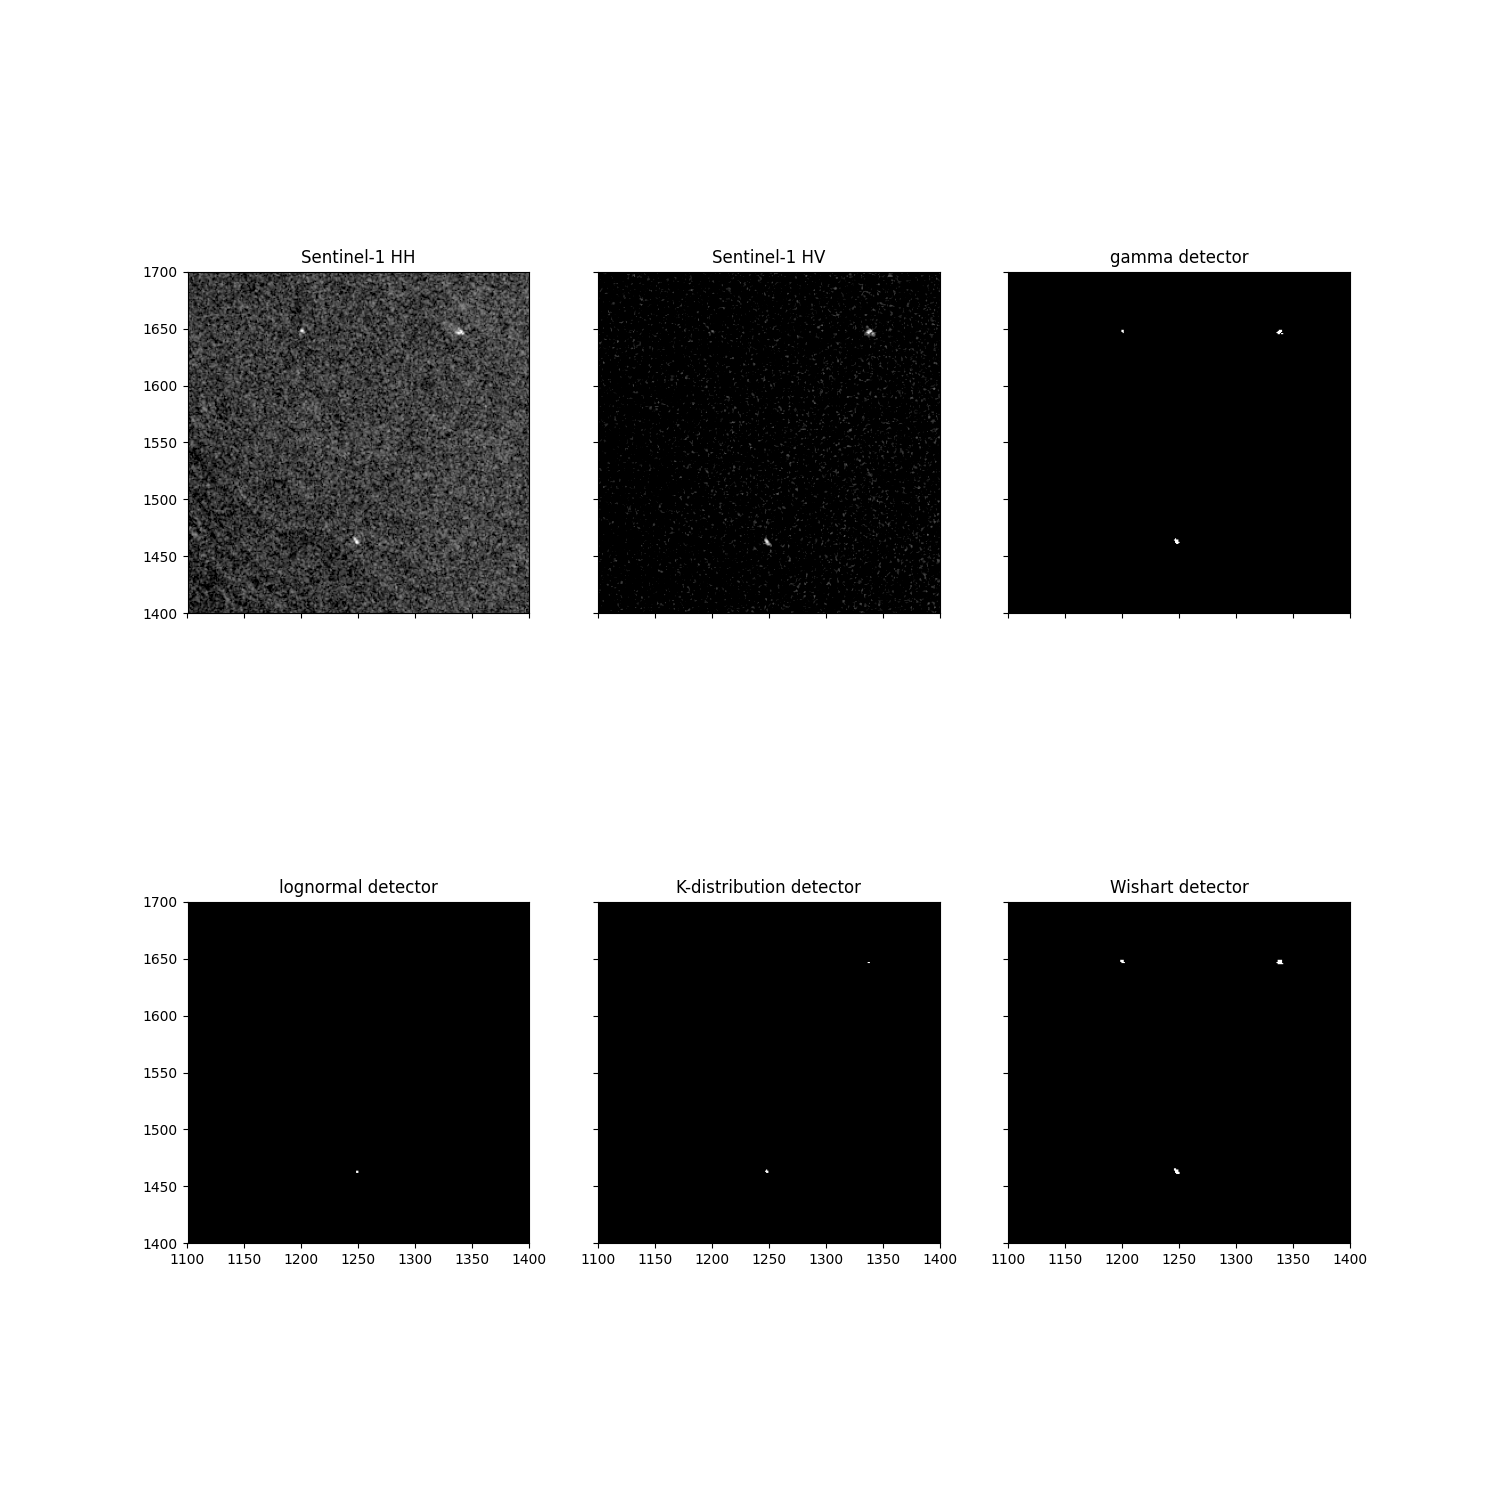

In [18]:
### Plot the results

fig, ax = plt.subplots(2,3, sharex=True, sharey=True, figsize=(15,15))

ax[0,0].imshow(db_image[0,...], vmin=-30, vmax=-5, cmap='gray')
ax[0,0].set_title('Sentinel-1 HH')
ax[0,0].set_xlim(xlim)
ax[0,0].set_ylim(ylim)

ax[0,1].imshow(db_image[1,...], vmin=-35, vmax=-15, cmap='gray')
ax[0,1].set_title('Sentinel-1 HV')

ax[0,2].imshow(gamma_outliers, cmap='gray')
ax[0,2].set_title('gamma detector')

ax[1,0].imshow(lognormal_outliers, cmap='gray')
ax[1,0].set_title('lognormal detector')

ax[1,1].imshow(k_outliers, cmap='gray')
ax[1,1].set_title('K-distribution detector')

ax[1,2].imshow(wishart_outliers, cmap='gray')
ax[1,2].set_title('Wishart detector')

Text(0.5, 1.0, 'IDPOLRAD detector')

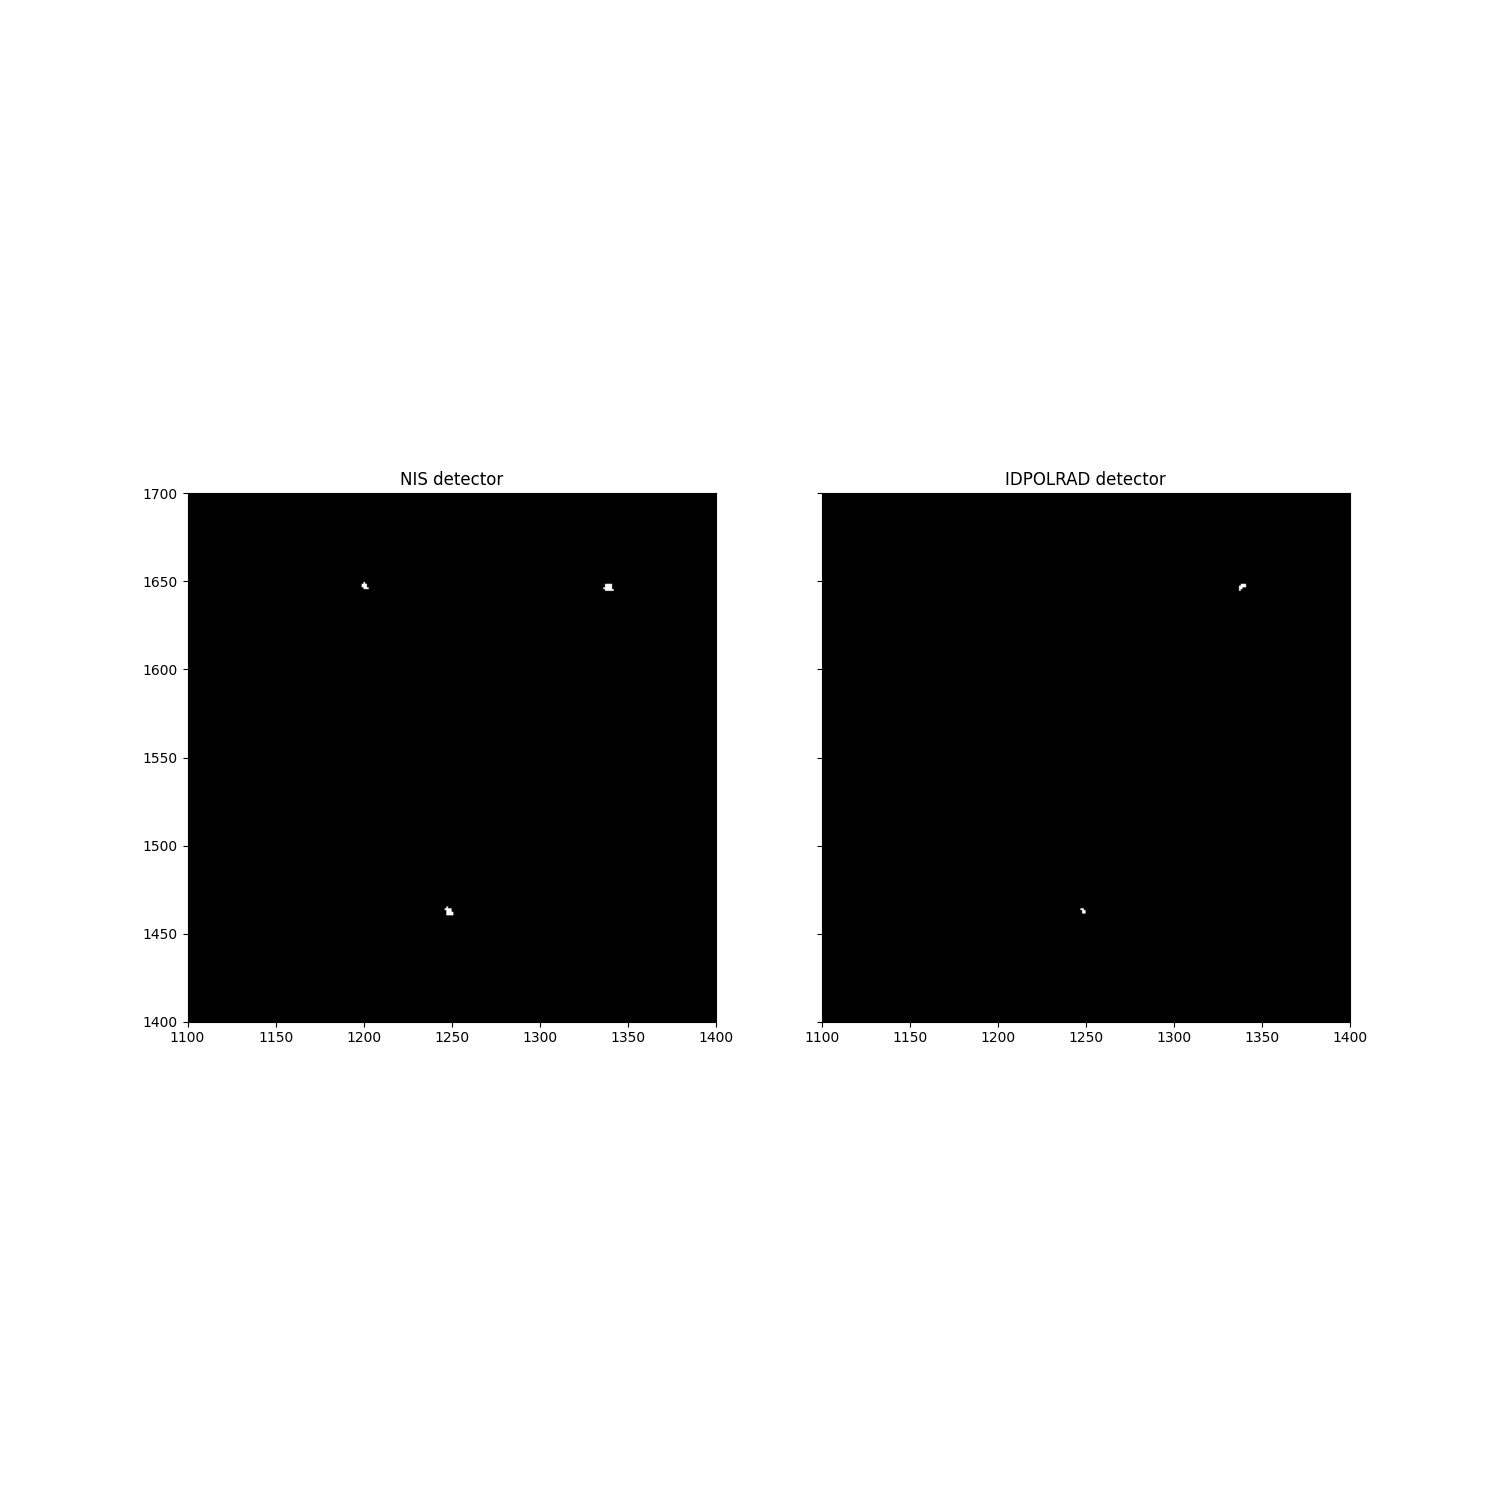

In [20]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(15,15))

ax[0].imshow(nis_outliers, cmap='gray')
ax[0].set_title('NIS detector')
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)

ax[1].imshow(idpolrad_outliers, cmap='gray')
ax[1].set_title('IDPOLRAD detector')